In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix
#!pip install seaborn
import seaborn as sns

In [2]:
def read_data(file):
    df = pd.read_csv(file)
    #print(df.head())
    return df


def check_null(df):
    print('checking for null')
    print(df.isnull().sum())
    
    df = df.dropna()
    print('checking for null')
    print(df.isnull().sum())
    return df
    
def preprocessing(data):
    data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])
    
    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1=data.join(cat_list)
        data=data1

    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    data_vars=data.columns.values.tolist()
    to_keep=[i for i in data_vars if i not in cat_vars]
    
    final_data=data[to_keep]
    
    
    final_data.columns = final_data.columns.str.replace('.','_')
    final_data.columns = final_data.columns.str.replace(' ','_')
    return final_data    

In [4]:
def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
    return X_train, X_test, y_train, y_test


In [5]:
def over_sampling_target_class(X_train, y_train):
    ### Over-sampling using SMOTE 
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
    print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
    print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
    print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['y']
 
    return X_train, y_train

In [3]:
def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

In [4]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [5]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [6]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred,average='micro')
    recall = recall_score(y_true, y_pred,average='micro')
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2),'entropy': round(entropy, 2)}

In [7]:

def create_roc_auc_plot(y_pred, y_true,title):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    fpr,tpr,_ = metrics.roc_curve(y_pred, y_true) 
    plt.plot(fpr,tpr)
    plt.savefig(title)
    
def create_confusion_matrix_plot(y_pred, y_true,title):
    import matplotlib.pyplot as plt
    #from sklearn.metrics import plot_confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    # Creating a normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    plt.savefig(title)    
    

In [8]:

def hyper_parameter_tuning(X_train, y_train):
    # define random parameters grid
    n_estimators = [5,21,51,101] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

In [12]:
df = read_data('banking.csv')
df = check_null(df)
df.head()

checking for null
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
checking for null
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [14]:
df = preprocessing(df)
X_train, X_test, y_train, y_test = train_test_split(df)

X_train, y_train = over_sampling_target_class(X_train, y_train)

length of oversampled data is  51166
Number of no subscription in oversampled data 25583
Number of subscription 25583
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [15]:
model = training_basic_classifier(X_train,y_train)
y_pred = predict_on_test_data(model,X_test)
y_pred_prob = predict_prob_on_test_data(model,X_test)

In [16]:

run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

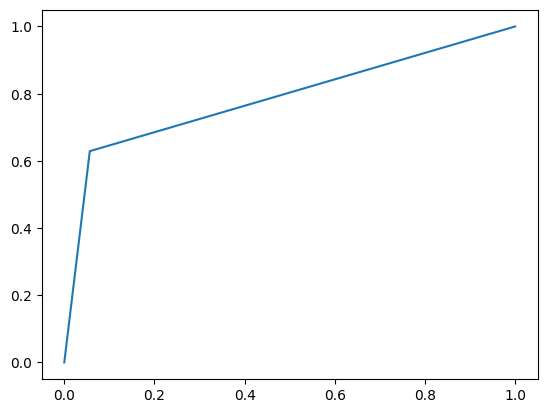

In [23]:
create_roc_auc_plot(y_pred,y_test)

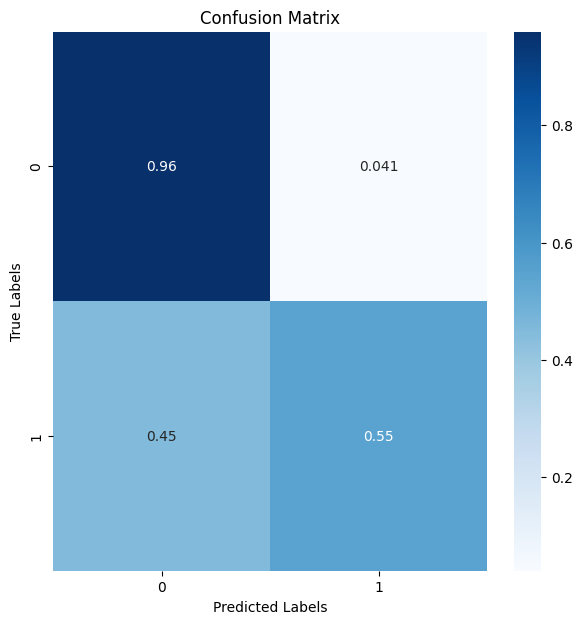

<Figure size 640x480 with 0 Axes>

In [32]:
create_confusion_matrix_plot(y_pred,y_test)

In [9]:
# MLFLOW

import mlflow

In [33]:
experiment_name = "basic_classifier" ##basic classifier
run_name="term_deposit"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.55, 'entropy': 0.2}


In [44]:
def create_experiment(experiment_name,run_name,run_metrics,model , conf_metrics_path = None, roc_auc_path = None, run_params=None):
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run():
        
        if not run_params == None:
            for params in run_params:
                mlflow.log_param(params,run_params[params])
        
        for metric in run_metrics:
            mlflow.log_metric(metric,run_metrics[metric])
            
        mlflow.sklearn.log_model(model,'model')    
        
        if not conf_metrics_path == None:
            mlflow.log_artifact(conf_metrics_path,'confusion_metrics')
        
        if not roc_auc_path == None:
            mlflow.log_artifact(roc_auc_path,'confusion_metrics')
            
        mlflow.set_tag('tag1',"Random_Forest")
       # mlflow.set_tag({'tag2':'random_search_cv','tag3':'Production'})
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
        
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))   

In [46]:
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png', 'roc_auc_curve.png')

Run - term_deposit is logged to Experiment - basic_classifier


In [47]:
import mlflow
experiment_name = "optimized model"
run_name="Random_Search_CV_Tuned_Model"
model_tuned,best_params = hyper_parameter_tuning(X_train, y_train)
run_params = best_params

y_pred = predict_on_test_data(model_tuned,X_test) #will return the predicted class
y_pred_prob = predict_prob_on_test_data(model_tuned,X_test) #model.predict_proba(X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\users\chinmay\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random grid:  {'n_estimators': [5, 21, 51, 101], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 101, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 120, 'bootstrap': True}  



c:\users\chinmay\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [48]:

for param in run_params:
    print(param, run_params[param])

n_estimators 101
min_samples_split 2
min_samples_leaf 1
max_features auto
max_depth 120
bootstrap True


In [49]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png', 'roc_auc_curve.png',run_params)

2023/06/07 15:49:25 INFO mlflow.tracking.fluent: Experiment with name 'optimized model' does not exist. Creating a new experiment.


Run - Random_Search_CV_Tuned_Model is logged to Experiment - optimized model


# IRIS


In [10]:
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()

In [11]:
from sklearn.model_selection import train_test_split
    
X_train,X_test,y_train,y_test =  train_test_split(iris.data,iris.target)


In [12]:
iris_model = training_basic_classifier(X_train,y_train)
iris_pred = iris_model.predict(X_test)
iris_pred_prob = predict_prob_on_test_data(iris_model,X_test)

In [13]:
run_metrics_iris = get_metrics(y_true = y_test,y_pred = iris_pred ,y_pred_prob=iris_pred_prob)

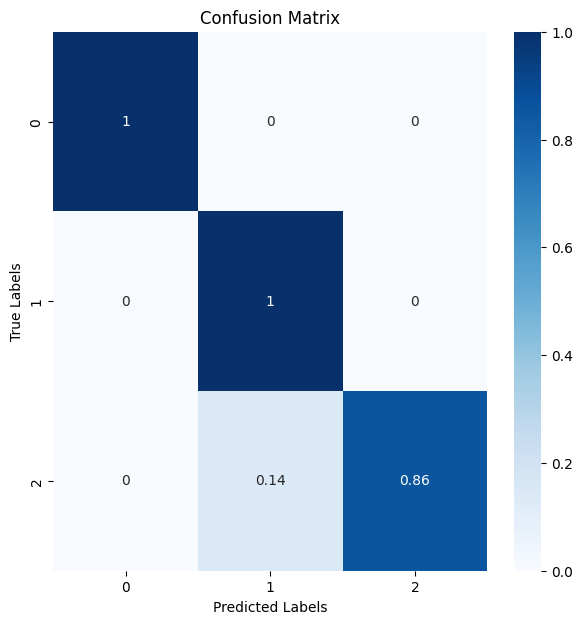

<Figure size 640x480 with 0 Axes>

In [14]:
create_confusion_matrix_plot(iris_pred,y_test,'iris_conf.png')

In [15]:
experiment_name = 'iris_data ' 
run_name = 'first_run'




In [20]:
import mlflow
def create_experiment(experiment_name,run_name,model,run_metrics,conf_path =None,run_params = None ):
    
    with mlflow.start_run():
        if not run_params==None:
            for param in run_params:
                mlflow.log_param(param,run_params[param])

        for metric in run_metrics:
            mlflow.log_metric(metric,run_metrics[metric])


        mlflow.sklearn.log_model(model,'reg_model')

        if not conf_path==None:
            mlflow.log_artifact(conf_path,'confusion_metrics_img')

        mlflow.set_tag('tag1',"Random_Forest")
           # mlflow.set_tag({'tag2':'random_search_cv','tag3':'Production'})
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})  
    #mlflow.end_run()   

    print(f'Run {run_name} is logged to Exp {experiment_name}')    

In [21]:
create_experiment(experiment_name,run_name, iris_model , run_metrics_iris , conf_path = 'iris_conf.png' ,run_params=None)

Run first_run is logged to Exp iris_data 


In [ ]:
#Execute the create_exp function and log exp

In [23]:
from datetime import datetime
experiment_name = 'iris_classifier_'+str(datetime.now().strftime("%d-%m-%y")) #basic classifier
run_name = 'iris_classifier_'+str(datetime.now().strftime("%d-%m-%y"))

create_experiment(experiment_name,run_name,iris_model,run_metrics_iris, conf_path = 'iris_conf.png' ,run_params=None)




Run iris_classifier_07-06-23 is logged to Exp iris_classifier_07-06-23


# Adding model to registry

# Method 1

In [34]:
def create_expand_reg_model(experiment_name,run_name,iris_model,
                            run_metrics_iris, conf_path = 'iris_conf.png' ,
                            run_params=None):
    
    mlflow.set_tracking_uri('http://localhost:5000')
    #use above if using backend db
    
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name) as run:
        
        if not run_params==None:
            for param in run_params:
                mlflow.log_param(param,run_params[param])

        for metric in run_metrics_iris:
            mlflow.log_metric(metric,run_metrics_iris[metric])


        if not conf_path==None:
            mlflow.log_artifact(conf_path,'confusion_metrics_img')

        mlflow.set_tag('tag1',"Random_Forest")
           # mlflow.set_tag({'tag2':'random_search_cv','tag3':'Production'})
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})  
    #mlflow.end_run()   

    mlflow.sklearn.log_model(iris_model,'model',registered_model_name= 'iris_classifier')
    
    print(f'Run {run_name} is logged to Exp {experiment_name}')    
        
    


In [35]:

create_expand_reg_model(experiment_name,run_name,iris_model,run_metrics_iris, conf_path = 'iris_conf.png' ,run_params=None)



Successfully registered model 'iris_classifier'.
2023/06/07 22:11:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: iris_classifier, version 1


Run iris_classifier_07-06-23 is logged to Exp iris_classifier_07-06-23


Created version '1' of model 'iris_classifier'.


# Method  2:
after all exp are run and model to be registered is selected,for this model,
we will need the run_id as part of the runs:URI argument

In [37]:
result = mlflow.register_model(
        'runs:/e0b09cb936f84d09b78ea03c596e3183/reg_model','iris_class_2')

Successfully registered model 'iris_class_2'.
2023/06/07 22:22:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: iris_class_2, version 1
Created version '1' of model 'iris_class_2'.


# Fetching an MLflow Model from Model Registry

In [38]:
import mlflow.pyfunc

In [40]:
model_name = 'iris_class_2'
model_version = 1

model = mlflow.pyfunc.load_model(model_uri=f'models:/{model_name}/{model_version}')

y_pred = model.predict(X_test)
print(y_pred)

[2 2 1 0 1 0 2 0 2 2 2 1 0 1 2 1 2 0 1 1 0 0 0 0 2 1 1 1 0 1 2 2 0 1 0 1 0
 2]


# Fetching latest model by stage 

In [41]:
client = mlflow.tracking.MlflowClient()

client.transition_model_version_stage(
    name = 'iris_class_2',
    version = 1,
    stage = 'Production')

#iris_class_2 moves to production

<ModelVersion: aliases=[], creation_timestamp=1686190933087, current_stage='Production', description='', last_updated_timestamp=1686192338325, name='iris_class_2', run_id='e0b09cb936f84d09b78ea03c596e3183', run_link='', source='file:///C:/Users/Chinmay/Desktop/MLOPS/mlruns/0/e0b09cb936f84d09b78ea03c596e3183/artifacts/reg_model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [42]:
#since it has moved to prodction,we will fetch the model
model_name = 'iris_class_2'
stage = 'Production'

model = mlflow.pyfunc.load_model(model_uri=f'models:/{model_name}/{stage}')

y_pred = model.predict(X_test)
print(y_pred)

[2 2 1 0 1 0 2 0 2 2 2 1 0 1 2 1 2 0 1 1 0 0 0 0 2 1 1 1 0 1 2 2 0 1 0 1 0
 2]


In [ ]:
# Serving an MLMODEL from Model Registry

# Serving an MLFLOW model from Model Regisrty

In [43]:
mlflow.set_tracking_uri('http://localhost:5000')

# DO Prediction

In [46]:
#After running from the ancnoda promt

import requests
inference_request={
    'dataframe_records':[[6.6,7.7,1.2,3.1]]
}

endpoint = 'http://localhost:1234/invocations'
response = requests.post(endpoint,json = inference_request)
print(response.text)

{"predictions": [0]}


In [47]:
X_test

array([[6.4, 2.8, 5.6, 2.1],
       [6.3, 3.3, 6. , 2.5],
       [5.5, 2.3, 4. , 1.3],
       [5.1, 3.3, 1.7, 0.5],
       [5.6, 2.7, 4.2, 1.3],
       [5. , 3.3, 1.4, 0.2],
       [7.7, 3. , 6.1, 2.3],
       [5.3, 3.7, 1.5, 0.2],
       [6.4, 3.2, 5.3, 2.3],
       [5.8, 2.8, 5.1, 2.4],
       [6.7, 3.3, 5.7, 2.1],
       [5.7, 2.9, 4.2, 1.3],
       [5.1, 3.4, 1.5, 0.2],
       [6.1, 2.9, 4.7, 1.4],
       [6.9, 3.1, 5.4, 2.1],
       [6.4, 3.2, 4.5, 1.5],
       [7.7, 2.8, 6.7, 2. ],
       [4.8, 3. , 1.4, 0.3],
       [6. , 2.2, 5. , 1.5],
       [5.7, 2.8, 4.1, 1.3],
       [4.8, 3.4, 1.6, 0.2],
       [5. , 3. , 1.6, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [4.4, 3. , 1.3, 0.2],
       [6. , 3. , 4.8, 1.8],
       [4.9, 2.5, 4.5, 1.7],
       [5.2, 2.7, 3.9, 1.4],
       [5.6, 2.9, 3.6, 1.3],
       [5.8, 4. , 1.2, 0.2],
       [5.1, 2.5, 3. , 1.1],
       [7.2, 3.2, 6. , 1.8],
       [6.3, 2.7, 4.9, 1.8],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 2.4, 3.3, 1. ],
       [5.1, 3

In [53]:
inference_req = {
    'dataframe_records':X_test.tolist()
}

endpoint = 'http://localhost:1234/invocations'
response = requests.post(endpoint,json = inference_req)
print(response)

<Response [200]>


In [54]:
print(response.text)

{"predictions": [2, 2, 1, 0, 1, 0, 2, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0, 2]}
